# PathFinding Data PreProcessing
* find subject data
* find experiment and eyetracking files
* combine experiment files for single subject to consolidate
* combine eyetracking files for single subject and pre-process
* performance analysis of PathFinding experiments

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [3]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Writing graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
import time

In [2]:
OG_DATA_PATH = './'

condition = 'SingleC' # Single, Dyadic, SingleC
DATA_PATH = './Data {}/'.format(condition)
LAB_DATA_PATH = "D:/StefanSpaRe/DataBackUp/seahavenlab/"
LAB_DATA_PATH += condition.lower() + '/';
DATA_PATH = LAB_DATA_PATH # Comment out when not in lab

# print(LAB_DATA_PATH);
RESSOURCES_PATH = './Ressources/'
#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')

PROCESSED_DATA_PATH = './Results/' + condition + '/'
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

PROCESSED_GRAPH_PATH = './Results/' + condition + '/Graphs/'
PROCESSED_GRAPH_FOLDER = sorted([f for f in os.listdir(PROCESSED_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

# Extracting all subject IDs from the data folder
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)

#subIDs = subIDs[:3]
#subIDs = [1023] # remove to do for all subIDs
print(subIDs)

[1010 1019 1056 1068 1072 1073 1075 1077 1079 1080]


In [44]:
dests_A = ["Windmill-TaskBuilding_10_1", "TaskBuilding_41", "TaskBuilding_39", "TaskBuilding_7", \
          "Building_186", "TaskBuilding_29", "TaskBuilding_1", "TaskBuilding_9", "TaskBuilding_4", \
          "TaskBuilding_53"]
dests_B = dests_A.copy()
dests_B.reverse()


['TaskBuilding_53',
 'TaskBuilding_4',
 'TaskBuilding_9',
 'TaskBuilding_1',
 'TaskBuilding_29',
 'Building_186',
 'TaskBuilding_7',
 'TaskBuilding_39',
 'TaskBuilding_41',
 'Windmill-TaskBuilding_10_1']

## Filtering Subject IDs per condition

Graphs to be created:

* Conditions: Single, SingleC (26 + 10 subjects)
    * 1 per sub - Total graph for each subject
    * 9 per sub - Graph for each path for each subject (along with indication of failure and success)
    * 1 per condition - Average total graphs for A 
    * 1 per condition - Average total graphs for B 
    * 9 per condition - Average graphs for each path in both A & B
    * 9 per condition - Average graphs for each path in A 
    * 9 per condition - Average graphs for each path in B 
    

* Conditions: Dyadic Follower, Dyadic Leader (8 + 8 subjects)
    * 1 per sub - Total graph for each subject (along with indication of follower or leader)
    * 9 per sub - Graph for each path for each subject (along with indication of failure and success)
    * 1 per condition - Average total graphs for A 
    * 1 per condition - Average total graphs for B 
    * 9 per condition - Average graphs for each path in both A & B
    * 9 per condition - Average graphs for each path in A 
    * 9 per condition - Average graphs for each path in B 
    
Total number of graphs created: (26+10+8+8) * (1+9) + 4 * (1+1+9+9+9) = 636


In [53]:
subject_performance = pd.read_csv(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv')

direction = "A" # A or B
role = "L" # L or F
pathnum = "1" # all, or 1-9

dests = dests_A if direction == "A" else dests_B
reduced = subject_performance[subject_performance.Condition == direction];
if condition == "Dyadic": 
    check = True if role == "L" else False
    reduced = reduced[reduced["Leader?"] == check];
    
subIDs = list(reduced.SubjectID)
if pathnum != "all": successes = list(reduced["P"+pathnum+":Success"])

In [4]:
subject_performance

,SubjectID,Condition,Dyadic?,Leader?,SessionID,P1:Success,P1:TimeSec,P1:Time After Guide,P1:Distance Covered,P1:Dist After Fail,...,P8:TimeSec,P8:Time After Guide,P8:Distance Covered,P8:Dist After Fail,P9:Success,P9:TimeSec,P9:Time After Guide,P9:Distance Covered,P9:Dist After Fail,#Success
0,1010,A,False,False,NaN,True,103.283452,-196.716548,476.096039,0.000000,...,149.935175,-233.064825,641.026161,0.000000,False,349.954884,17.954884,1619.421569,91.207877,7
1,1019,B,False,False,NaN,True,121.585427,-210.414573,588.410275,0.000000,...,62.756872,-242.243128,304.284589,0.000000,True,126.389681,-173.610319,626.570717,0.000000,9
2,1056,B,False,False,NaN,True,99.185621,-232.814379,474.406991,0.000000,...,376.036466,71.036466,1713.066832,356.673271,True,101.787637,-198.212363,490.774520,0.000000,7
3,1068,A,False,False,NaN,True,129.268349,-170.731651,574.518955,0.000000,...,117.311292,-265.688708,553.495537,0.000000,False,474.197720,142.197720,2198.983763,698.273760,7
4,1072,A,False,False,NaN,True,106.815908,-193.184092,528.177114,0.000000,...,113.280268,-269.719732,562.248210,0.000000,True,150.568494,-181.431506,670.313338,0.000000,8
5,1073,A,False,False,NaN,False,352.014228,52.014228,1698.387879,255.775648,...,175.417123,-207.582877,829.897009,0.000000,False,454.078002,122.078002,2196.108475,600.500869,5
6,1075,B,False,False,NaN,True,96.997154,-235.002846,450.548992,0.000000,...,58.880095,-246.119905,284.709058,0.000000,True,97.315090,-202.684910,476.694398,0.000000,9
7,1077,A,False,False,NaN,True,102.892725,-197.107275,480.416954,0.000000,...,211.720585,-171.279415,976.365778,0.000000,True,100.524325,-231.475675,467.020851,0.000000,7
8,1079,B,False,False,NaN,True,294.374525,-37.625475,1409.264233,0.000000,...,345.073664,40.073664,1600.080064,195.790279,True,274.738379,-25.261621,1269.599908,0.000000,7
9,1080,A,False,False,NaN,True,137.255427,-162.744573,659.431672,0.000000,...,125.162962,-257.837038,555.606218,0.000000,False,432.332893,100.332893,1953.778391,484.897133,6


In [49]:
subIDs
successes
dests

['TaskBuilding_53',
 'TaskBuilding_4',
 'TaskBuilding_9',
 'TaskBuilding_1',
 'TaskBuilding_29',
 'Building_186',
 'TaskBuilding_7',
 'TaskBuilding_39',
 'TaskBuilding_41',
 'Windmill-TaskBuilding_10_1']

## Graph Creation
* The graph creation involves the following steps:
    * creating the edge list
        * Remove non Fixations (SampleSize <= 21) 
        * Remove all noHouse hits 
        * Remove all noHit hits 
        * Remove all self repetitions
        * Shift the edgelist by one row and create chronology 
    * Use NetworkX to build the graph
    * Plot the graph onto the city map (using map coordinates)

Subject 1010 started - 1/6
	Mean/Std Degree: 2.70/2.30
	Maxmimum Degree of 12.00 is 4.04 sigma away from the mean
	Edge list saved
	Graph PNG saved
Subject 1068 started - 2/6
	Mean/Std Degree: 3.37/1.83
	Maxmimum Degree of 8.00 is 2.53 sigma away from the mean
	Edge list saved
	Graph PNG saved
Subject 1072 started - 3/6
	No NoHits found!
	Mean/Std Degree: 2.67/1.22
	Maxmimum Degree of 6.00 is 2.73 sigma away from the mean
	Edge list saved
	Graph PNG saved
Subject 1073 started - 4/6
	No NoHits found!
	Mean/Std Degree: 3.01/1.68
	Maxmimum Degree of 9.00 is 3.57 sigma away from the mean
	Edge list saved
	Graph PNG saved
Subject 1077 started - 5/6
	No NoHits found!
	Mean/Std Degree: 2.45/0.84
	Maxmimum Degree of 4.00 is 1.84 sigma away from the mean
	Edge list saved
	Graph PNG saved
Subject 1080 started - 6/6
	No NoHits found!
	Mean/Std Degree: 2.43/0.90
	Maxmimum Degree of 5.00 is 2.85 sigma away from the mean
	Edge list saved
	Graph PNG saved
	Centrality Dataframe saved
Done


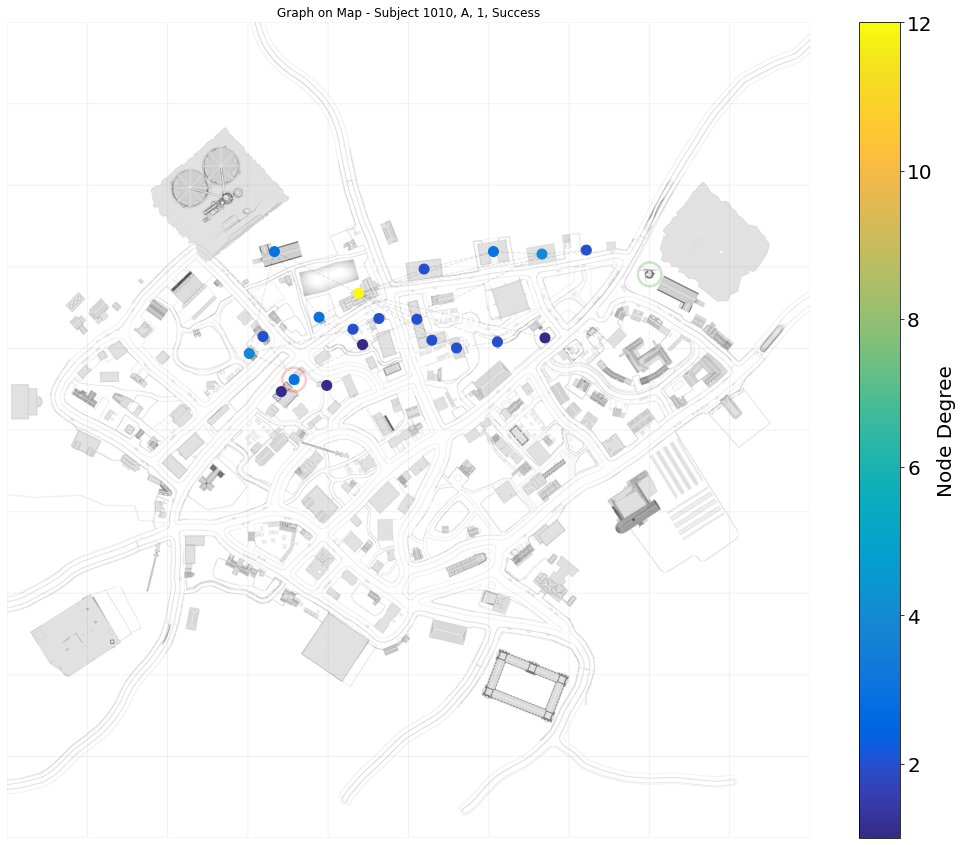

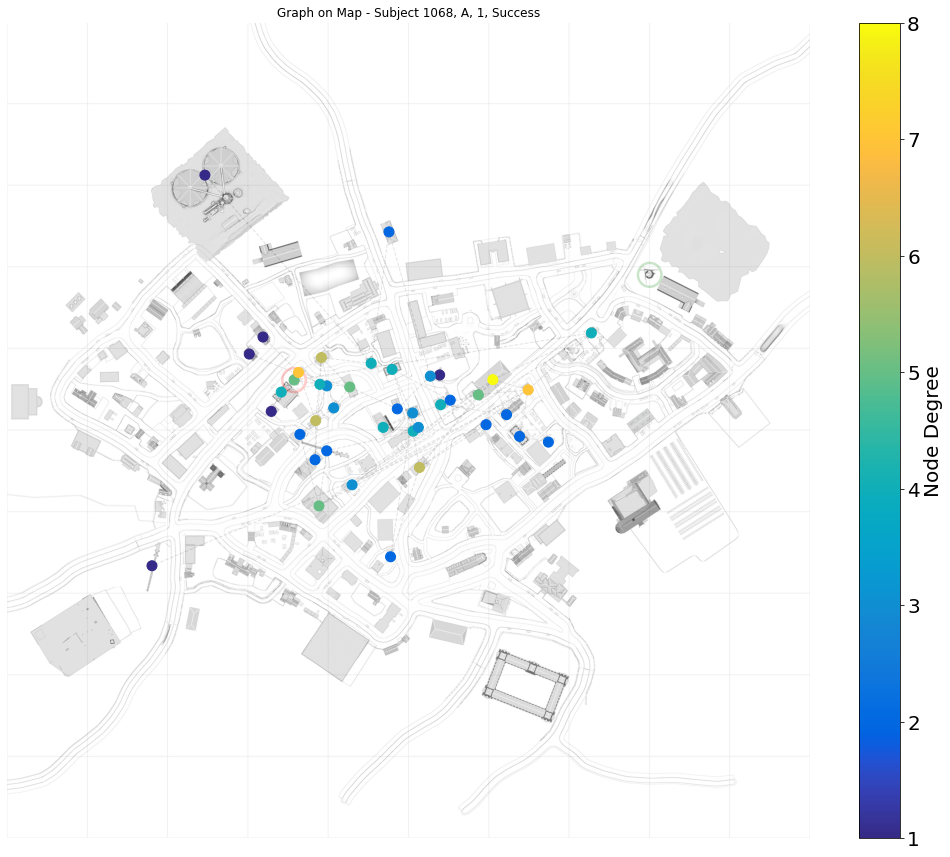

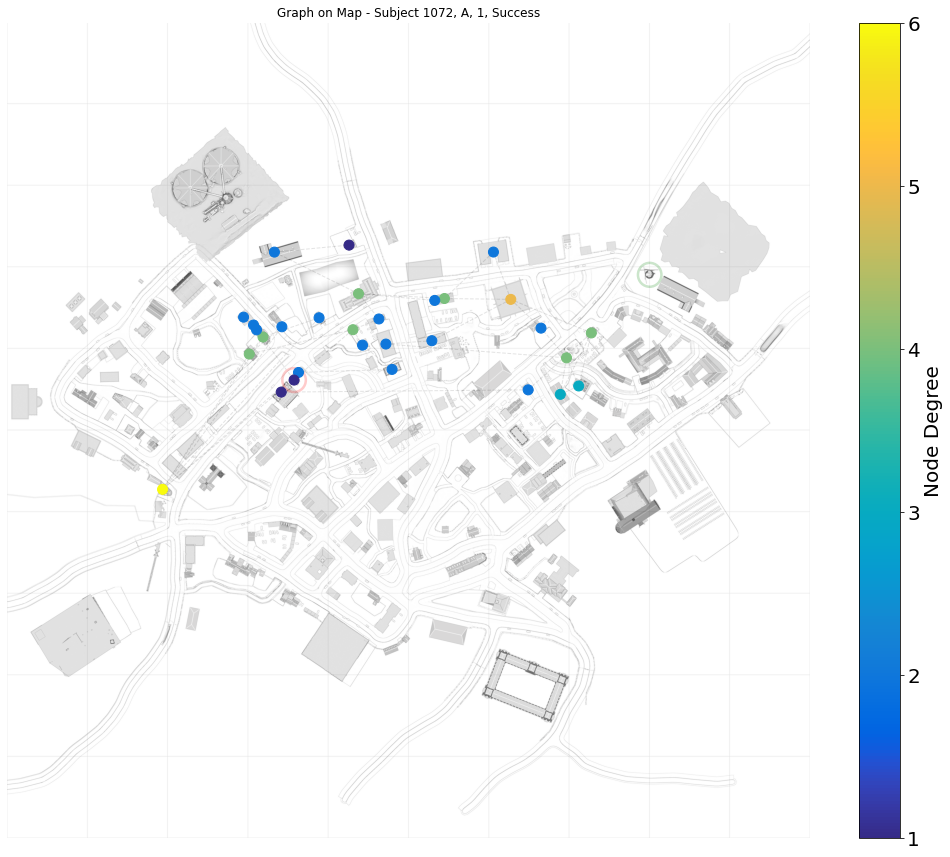

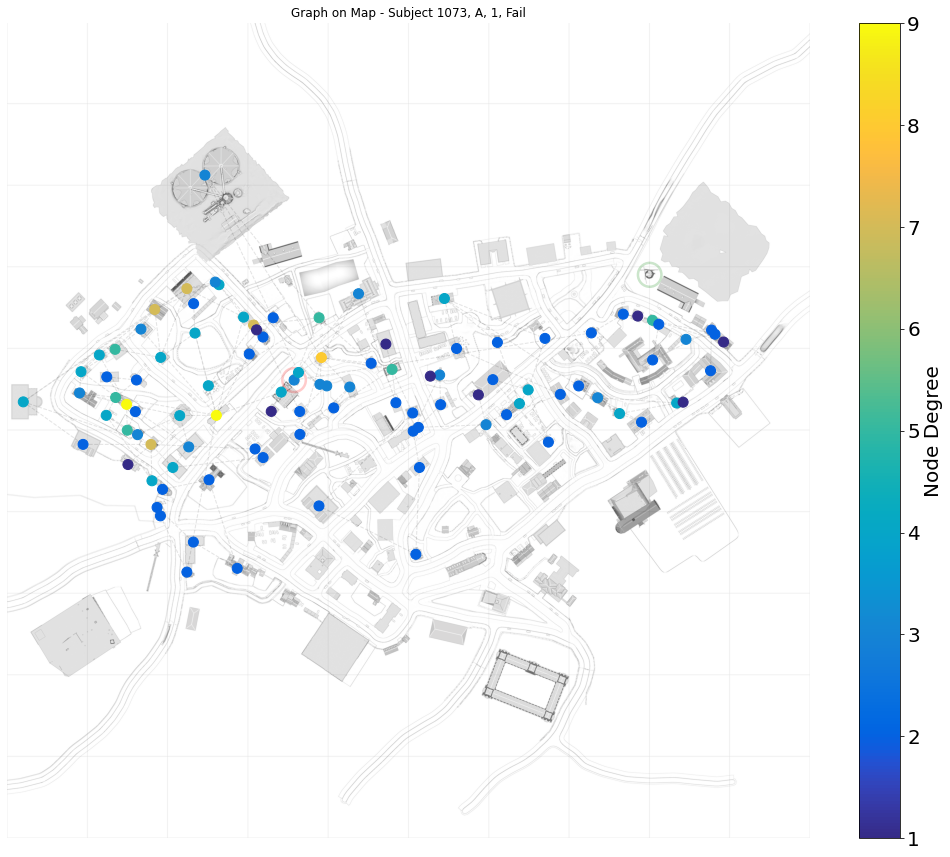

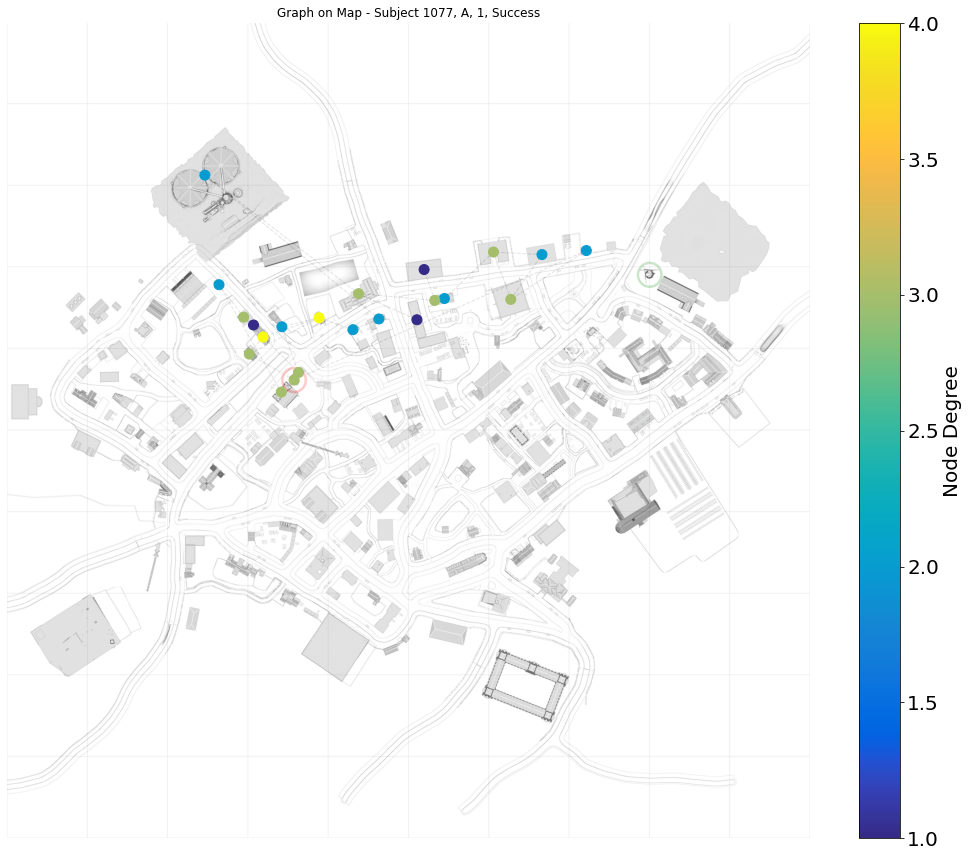

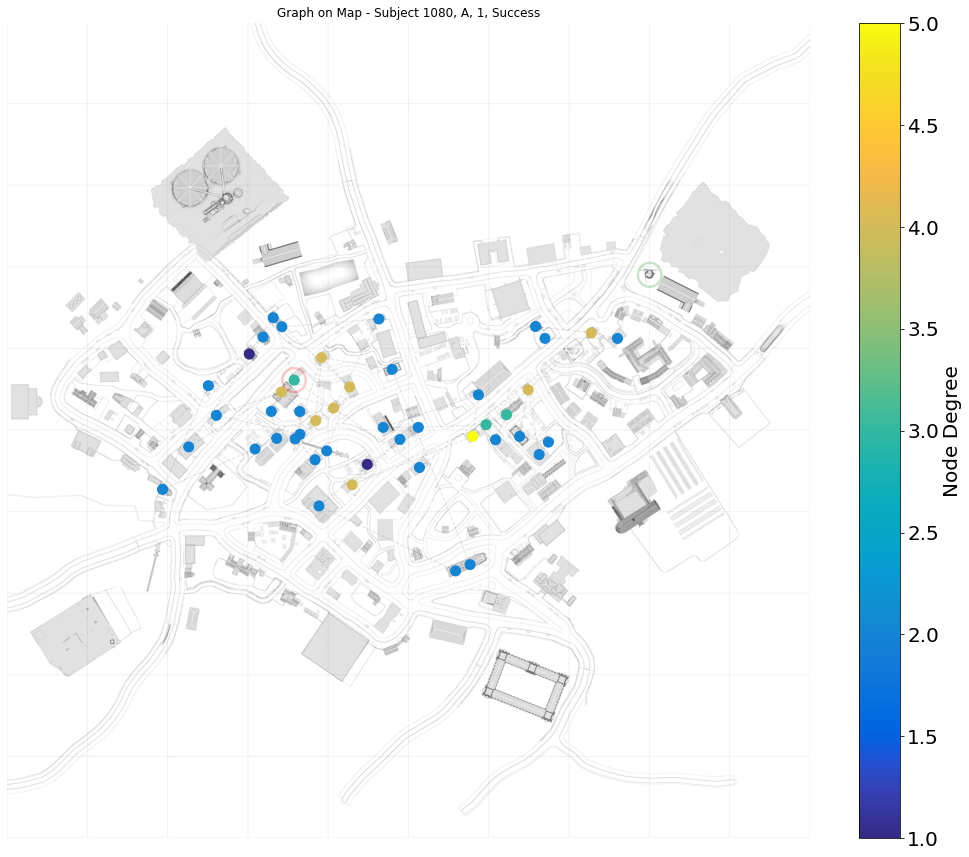

In [55]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
EdgeList_save_bool = True # if you want to save the edge list 
Graph_save_img_bool = True # if you want to save the graph as an image
plot_edges_bool = True # if you want to plot the graph's edges
save_centrality = True # if you want to save the centrality dataframe (node degree) as csv 

subcount = 0 # count subjects

fixation_time = 0.2333333

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")

# Dataframe for degrees with colums = subject + houselist
centrality_df = pd.DataFrame(columns= [*['Subject'], *np.unique(houselist.target_collider_name)])



# --------- MAIN PART ---------
# load the files 
for index, subject in enumerate(subIDs):
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_interpolation_df')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                interpolated_data = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " interpolation dataframe!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 

    edge_list = pd.DataFrame(columns=['Edge1','Edge2'])

    
    if pathnum != "all":
        interpolated_data = interpolated_data[interpolated_data.PathNumber == int(pathnum)];

    # --------- EDGE LIST CREATION ---------

    # filter out Clusters with <=21 hits, 'NoHouse' hits, 'NoHit' hits and self repititions (with unique)
    transition = interpolated_data[interpolated_data.timeDiff>fixation_time]
    transition = transition[transition.ColliderName!='NoHouse']
    #transition = transition[transition.ColliderName!='NoHit']
    unique_count = transition.ColliderName.groupby((transition['ColliderName'] 
                                            != transition['ColliderName'].shift()).cumsum()).cumcount() + 1

    # Assign filtered gaze hits to the edge list 
    edge_list.Edge1 = transition[unique_count==1].ColliderName
    edge_list.reset_index(inplace=True, drop=True)

    # shift the gaze hits by one and add the last entry of Edge1 to the first of Edge 2
    edge_list.Edge2[1:len(edge_list)-1] = edge_list.Edge1[0:len(edge_list)-2]
    edge_list.loc[0, 'Edge2'] = edge_list.Edge1[len(edge_list)-1]
    edge_list.loc[len(edge_list)-1, 'Edge2'] = edge_list.Edge1[0]

    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

    # Remove the NoHit Node
    try:
        
        G.remove_node('NoHit')
    except:
        print("\tNo NoHits found!")
    
    degree_list = list(dict(G.degree).values())

    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)

    # create the coordinate dictionary and assign coordinates from the houselist to the graph nodes
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')


    
    
    # --------- ANALYSIS ---------

    # create degree list of the graph 
    sub_degree = dict(G.degree)
    
    
    mean_degree = np.nanmean(list(sub_degree.values()))
    std_degree = np.nanstd(list(sub_degree.values()))
    max_degree = max(list(sub_degree.values()))
    
    
    # add the subject ID to the dictionary
    sub_degree.update({'Subject': str(subject)})  
    # append the centrality df by the subjects degree list
    centrality_df = centrality_df.append(sub_degree, ignore_index=True)
    #centrality_df['betweenness'] = list(nx.betweenness_centrality(G))



    print('\tMean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
    print('\tMaxmimum Degree of ' 
          + str("{:.2f}".format(max_degree)) 
          + ' is ' +
          "{:.2f}".format((max_degree-mean_degree)/std_degree)
          + ' sigma away from the mean')



    # --------- PLOTTING ---------    

    if Plotting_bool == True:

        # plot the map
        fig = plt.figure(figsize=(20,15))
        ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
        tit = "Graph on Map - Subject " + str(subject) + ", " + direction + ", " + str(pathnum)
        if pathnum != "all" : tit += ", " + ("Success" if successes[index] else "Fail")
        if condition == "Dyadic": tit += ", " + "Leader" if role == "L" else "Follower"
        plt.title(tit)
        plt.xlim(0, 4096)
        plt.ylim(0, 4096)
        ax.set_frame_on(False)
        plt.axis('off')
        plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                 extent= ax.get_xlim() + ax.get_ylim(),
                 zorder=1, alpha=0.8)

        # Draw the graph 
        vmin = np.min(degree_list)
        vmax = np.max(degree_list)

        nx.draw_networkx_nodes(G,
                               node_pos, 
                               alpha = 1, 
                               node_size = 100, 
                               node_color=degree_list, 
                               cmap=parula_map)
        
        if plot_edges_bool == True:
            nx.draw_networkx_edges(G, 
                                   node_pos, 
                                   edge_color='k', 
                                   alpha=0.5, 
                                   width=1,
                                   style='dashed')


        if pathnum != "all":
            orig = dests[int(pathnum) - 1]
            dest = dests[int(pathnum)]
            orig_x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==orig].values[0]
            dest_x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==dest].values[0]
            
            orig_y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==orig].values[0]
            dest_y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==dest].values[0]
            
            orig_circle = plt.Circle((orig_x, orig_y), 60, color='g', fill=False, linewidth=2.5, alpha=1)
            dest_circle = plt.Circle((dest_x, dest_y), 60, color='r', fill=False, linewidth=2.5, alpha=1)
            plt.gca().add_patch(orig_circle)
            plt.gca().add_patch(dest_circle)
            
        sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Node Degree', size=20)

    else:
        Graph_save_img_bool = False


    # --------- SAVING ---------

    # save the edge list 
    if EdgeList_save_bool == True:
        # saving the subject info dataframe
        filename = str(subject) + "_" + direction + "_" + str(pathnum)
        if pathnum != "all" : filename += "_" + ("Succ" if successes[index] else "Fail")
        if condition == "Dyadic": filename += "_" + role
        filename += "_edgelist.csv"
        try:
            edge_list.to_csv(PROCESSED_GRAPH_PATH
                            + filename, 
                            index=False)

            print("\tEdge list saved")
        except:
            print("\tCould not save subject " + str(subject) + " edge list!")



    # save the graph as png 
    if Graph_save_img_bool == True:
        # saving the subject info dataframe
        filename = str(subject) + "_" + direction + "_" + str(pathnum)
        if pathnum != "all" : filename += "_" + ("Succ" if successes[index] else "Fail")
        if condition == "Dyadic": filename += "_" + role
        filename += "_Graph.png"
        try:
            plt.savefig(PROCESSED_GRAPH_PATH + filename,
                        format="PNG", 
                        facecolor='white',
                        transparent=False)

            
            print("\tGraph PNG saved")
        except:
            print("\tCould not save " + filename + " Graph as PNG!")

            
# Add the mean over both axes to the centrality df and save it 


house_mean_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=0))
house_mean_dict.update({'Subject': 'Mean'})  
                 
house_std_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].std(axis=0))
house_std_dict.update({'Subject': 'STD'})  
                
centrality_df = centrality_df.append(house_mean_dict, ignore_index=True)
centrality_df = centrality_df.append(house_std_dict, ignore_index=True)

subject_mean = centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=1)
subject_std = centrality_df.loc[:,centrality_df.columns[1:]].std(axis=1)
                 
centrality_df['Mean'] = subject_mean
centrality_df['STD'] = subject_std
    
        
if save_centrality == True: 
    # saving the subject info dataframe
    filename = direction + "_" + str(pathnum)
    if condition == "Dyadic": filename += "_" + role
    filename += "_centrality_df.csv"
    try:
        centrality_df.to_csv(PROCESSED_GRAPH_PATH
                        + filename, 
                        index=False)

        print("\tCentrality Dataframe saved")
    except:
        print("\tCould not save centrality dataframe!")



    
print('Done')
    

In [27]:
interpolated_data[interpolated_data.PathNumber == pathnum]

False

## Plotting the average subject graph

Average Graph PNG saved
Done


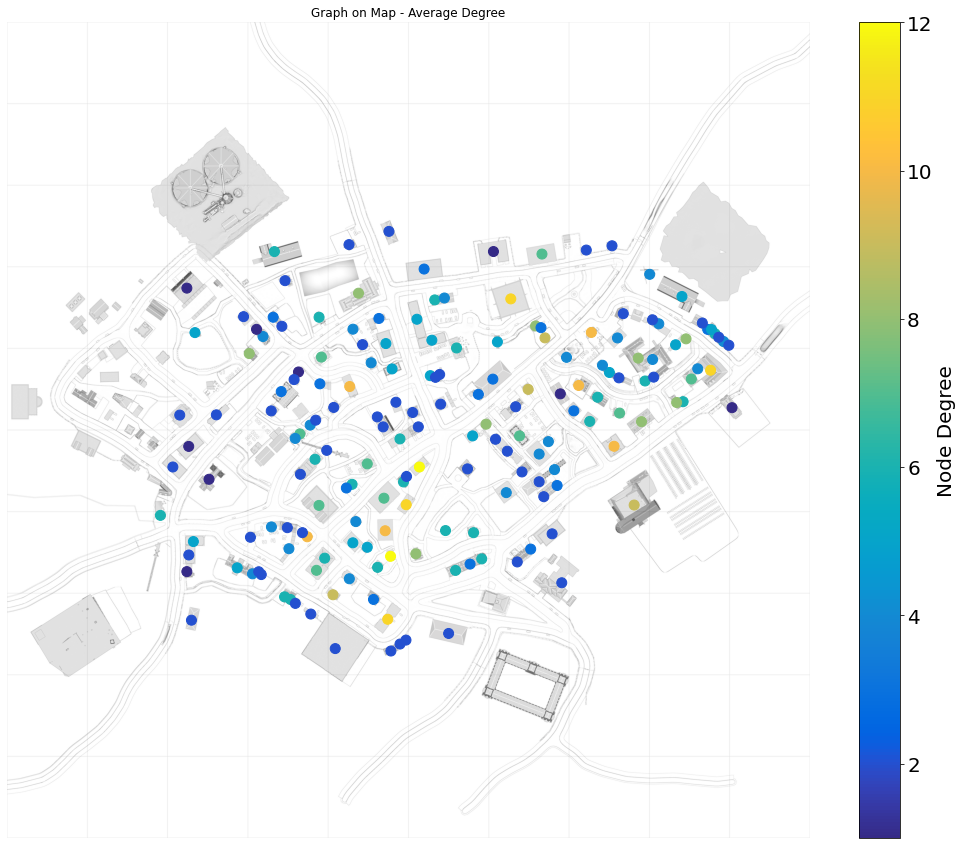

In [99]:
# --------- Preparation ---------
save_bool = True # if you want to save the graph as an image
plot_edges_bool = False # if you want to plot the graph's edges


# get the data files according to the subject
subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                         if f.startswith(str(1008)+'_edgelist')], key=str.lower)

if len(subject_folder) != 0:

    # open the JSON file as dictionary
    with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
        try:
            edge_list = pd.read_csv(f)
        except:
                print("\tCould not load subject " + str(subject) + " edgelist!")

    

# --------- GRAPH CREATION ---------

# create graph from edgelist
G = nx.Graph()
G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')
# Remove the NoHit Node
G.remove_node('NoHit')

# Setting the node coordinates of each node of the graph
# node list
nodelist = list(G.nodes)
nodearray = np.array(G.nodes)


# get the average degree over subjects and sort them according to the node order of the donor subject
mean_dict = centrality_df[centrality_df['Subject'] == 'Mean'].to_dict('records')[0]
mean_dict.pop('Mean')
mean_dict.pop('STD')
mean_dict.pop('Subject')

sorted_mean_degrees_dict = dict()
for node in nodelist:
    sorted_mean_degrees_dict[node] = mean_dict[node]
    
sorted_mean_degrees = list(sorted_mean_degrees_dict.values())


# create the coordinate dictionary and assign coordinates from the houselist to the graph nodes
node_pos = {}

for node in nodelist:
    # assign node coordinates
    x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
    y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
    node_pos[node] = (x,y) 

# set the graph's node coordinates attribute
nx.set_node_attributes(G, node_pos, 'coord')



# plot the map
fig = plt.figure(figsize=(20,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Graph on Map - Average Degree")
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.8)

# Draw the graph 
vmin = np.min(sorted_mean_degrees)
vmax = np.max(sorted_mean_degrees)

nx.draw_networkx_nodes(G,
                       node_pos, 
                       alpha = 1, 
                       node_size = 100, 
                       node_color=sorted_mean_degrees, 
                       cmap=parula_map)

if plot_edges_bool == True:
    nx.draw_networkx_edges(G, 
                           node_pos, 
                           edge_color='k', 
                           alpha=0.5, 
                           width=1,
                           style='dashed')
    
    
sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20)


# ------- SAVING ---------


# save the graph as png 
if save_bool == True:
    # saving the subject info dataframe
    try:
        plt.savefig(PROCESSED_DATA_PATH + "Graphs/" + "AverageDegree_Graph.png",
                    format="PNG", 
                    facecolor='white',
                    transparent=False)


        print("Average Graph PNG saved")
    except:
        print("Could not save average Graph as PNG!")



print('Done')

In [100]:
mean_dict = centrality_df[centrality_df['Subject'] == 'Mean'].to_dict('records')[0]
mean_dict.pop('Mean')
mean_dict.pop('STD')
mean_dict.pop('Subject')

sorted_mean_degrees = np.array(list(mean_dict.values()))[np.argsort(list(dict(G.nodes).keys()))]


In [91]:
centrality_df

,Subject,Building_100,Building_101,Building_102,Building_103,Building_104,Building_105,Building_106,Building_107,Building_108,...,TaskBuilding_55,TaskBuilding_6,TaskBuilding_7,TaskBuilding_8,TaskBuilding_9,Windmill-TaskBuilding_10_1,crane_1,crane_2,Mean,STD
0,1023,2,2,3,NaN,2,NaN,NaN,NaN,3,...,NaN,3,2,NaN,4,2,NaN,NaN,3.355705,2.010358
1,Mean,2,2,3,NaN,2,NaN,NaN,NaN,3,...,NaN,3,2,NaN,4,2,NaN,NaN,3.355705,2.010358
2,STD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting the average node degree distribution

C:\Users\experiment\.conda\envs\graphs\lib\site-packages\numpy\lib\histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\experiment\.conda\envs\graphs\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Frequency')

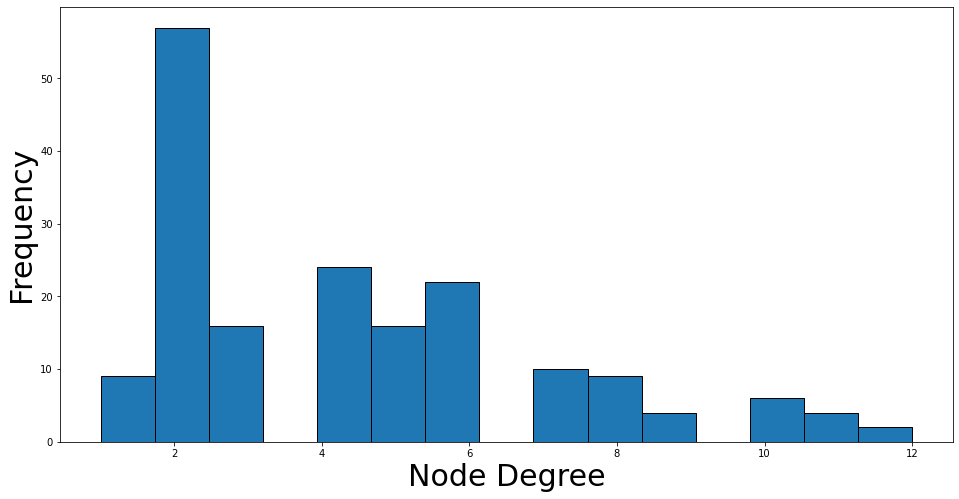

In [101]:
plt.figure(figsize=(16,8))
plt.hist(centrality_df.loc[len(centrality_df)-2][1:], bins=15, ec='black')
plt.xlabel("Node Degree", fontsize=30)
plt.ylabel("Frequency", fontsize=30)


In [102]:
mean_degree = centrality_df.loc[centrality_df[centrality_df.Subject == 'Mean'].index[0], 'Mean']
std_degree = centrality_df.loc[centrality_df[centrality_df.Subject == 'Mean'].index[0], 'STD']
max_degree = max(centrality_df[centrality_df.Subject == 'Mean'].iloc[0, 1:-2])

print('Mean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
print('Maxmimum Degree of ' 
      + str("{:.2f}".format(max_degree)) 
      + ' is ' +
      "{:.2f}".format((max_degree-mean_degree)/std_degree)
      + ' sigma away from the mean')



Mean/Std Degree: 4.40/2.69
Maxmimum Degree of 12.00 is 2.83 sigma away from the mean
